# Trilateration: Analysis

Given a set of RTT samples annotated by probe and anchor ID, and metadata about anchors including location, determine the linear fit between 

### Needful things

First, imports, utility functions, etc. required for analysis, and thaw out the datastore

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from collections import namedtuple

import warnings
warnings.filterwarnings("ignore") 

In [2]:
with pd.HDFStore('rtt.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']

### Analysis dataframe preparation

Load the raw RTT dataframe from dataprep, then alculate minumum RTT per anchor/probe pair, and join anchor and probe location to this dataframe.


In [3]:
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

Now calculate distance with a vectorization of the unit sphere distance algorithm.

In [4]:
min_df['tmp_aphi'] = (90.0 - min_df['alat']) * math.pi/180.0
min_df['tmp_pphi'] = (90.0 - min_df['plat']) * math.pi/180.0
min_df['tmp_atheta'] = min_df['alon'] * math.pi/180.0
min_df['tmp_ptheta'] = min_df['plon'] * math.pi/180.0
min_df['tmp_cos'] = ( np.sin(min_df['tmp_aphi']) * np.sin(min_df['tmp_pphi']) * 
                      np.cos(min_df['tmp_atheta'] - min_df['tmp_ptheta']) + 
                      np.cos(min_df['tmp_aphi']) * np.cos(min_df['tmp_pphi']) )
min_df['km'] = np.arccos(min_df['tmp_cos']) * 6371
del min_df['tmp_aphi']
del min_df['tmp_pphi']
del min_df['tmp_atheta']
del min_df['tmp_ptheta']
del min_df['tmp_cos']

### Basic exploration of the dataset

Plot of our RTT samples by minimum RTT and distance, along with a linear fit.

slope = 8.929151062690812, rvalue = 0.8778308056466325


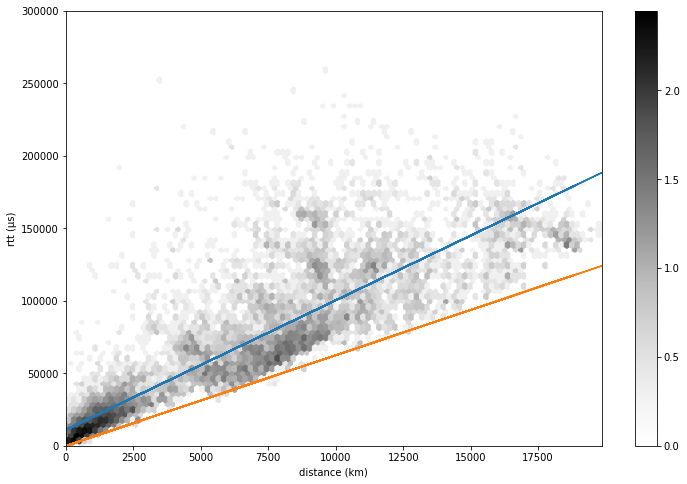

In [7]:
plt.figure(figsize=(12,8))

plot_df = min_df

x = plot_df['km']
y = plot_df['minrtt'] / 2
plt.hexbin(x, y, cmap="Greys", bins="log")
plt.colorbar()
plt.xlabel("distance (km)")
plt.ylabel("rtt (µs)")
plt.ylim(0,300000)

(slope, intercept, r, p, e) = scipy.stats.linregress(plot_df['km'],plot_df['minrtt']/2)
print("slope = {}, rvalue = {}".format(slope, r))
plt.plot(x, slope * x + intercept)
plt.plot(x, 6.25 * x)

This is a better R-value than we'd expect, actually. 

Let's derive an Internet Lightspeed Factor (ILF) deom the slope of the line over which all (almost all) samples remain. 

In [6]:
c = 299792458
ilf = (1e9 / 6.25) / c
ilf

0.5337025523170433

Is the correlation dependent on RTT, distance, or anchor? First, RTT bins:

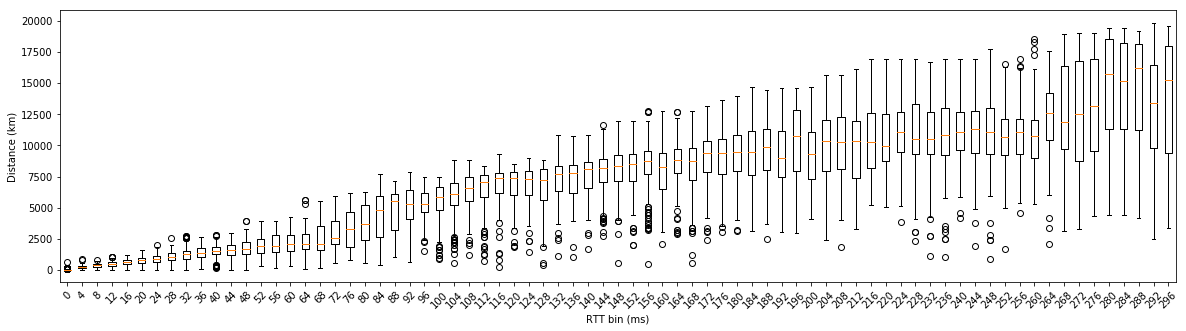

In [8]:
BINSKIP = 4000
BINMAX = 300000

rtt_bin = [0, BINSKIP]
km_sets = []

while rtt_bin[1] <= BINMAX:
    sub_df = min_df[(min_df['minrtt'] >= rtt_bin[0]) & (min_df['minrtt'] < rtt_bin[1])]
    # (m, b, r, p, e) = scipy.stats.linregress(sub_df['km'],sub_df['minrtt']/2)
    # print ("Between {} and {} µs, slope is {}, rvalue is {}".format(rtt_bin[0], rtt_bin[1], m, r))
    km_sets.append(sub_df['km'])
    rtt_bin[0] += BINSKIP
    rtt_bin[1] += BINSKIP

plt.figure(figsize=(20,5))
plt.boxplot(km_sets)
plt.xlabel("RTT bin (ms)")
plt.xticks(np.arange(1,BINMAX/BINSKIP + 1), np.arange(0, int(BINMAX/1000), int(BINSKIP/1000)), rotation=45)
plt.ylabel("Distance (km)")

Now, distance bins (these aren't very useful and are still in progress)

([<matplotlib.axis.XTick at 0x12b7c19e8>,
 <a list of 26 Text xticklabel objects>)

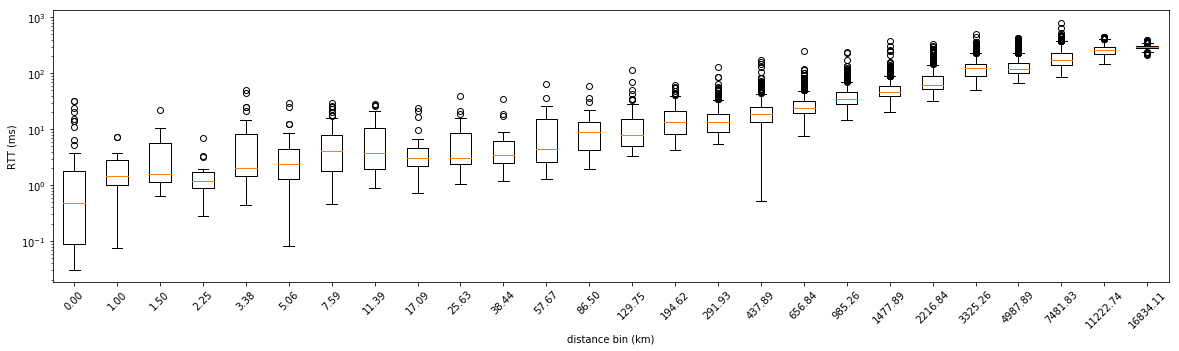

In [9]:
BINSTART = 1
BINMAX = 20000
BINFACTOR = 1.5

km_bin = [0, BINSTART]
rtt_sets = []
rtt_set_distances = []

while km_bin[0] <= BINMAX:
    sub_df = min_df[(min_df['km'] >= km_bin[0]) & (min_df['km'] < km_bin[1])]
    # (m, b, r, p, e) = scipy.stats.linregress(sub_df['km'],sub_df['minrtt']/2)
    # print ("Between {} and {} µs, slope is {}, rvalue is {}".format(rtt_bin[0], rtt_bin[1], m, r))
    rtt_sets.append(sub_df['minrtt'] / 1000)
    rtt_set_distances.append(km_bin[0])
    km_bin[0] = km_bin[1]
    km_bin[1] *= BINFACTOR
    
plt.figure(figsize=(20,5))
plt.boxplot(rtt_sets)
plt.xlabel("distance bin (km)")
plt.ylabel("RTT (ms)")
plt.yscale('log')
plt.xticks(np.arange(1,len(rtt_set_distances)+1), map(lambda x: "%4.2f" % x, rtt_set_distances), rotation=45)


Now look at goodness of fit on a per-anchor basis...

In [10]:
## TODO

### Error estimation

For each distance sample, calculate a distance from a minimum RTT based on a linear model, then determine the absolute value of the distance and plot an ECDF.

In [11]:
c = 299792458
def dist_for_rtt(rtt):
    return (c / 1e9) * ilf * rtt / 2

min_df['rtt_km'] = (c / 1e9) * ilf * (min_df['minrtt'] / 2)

In [12]:
## TODO

### Cartographic illustration

Select a few anchors and all close-by probes, and plot the linear model circles on the map. Build a system for doing this randomly, so people who read the paper can choose their own examples.

In [13]:
from mpl_toolkits.basemap import Basemap

First, let's warm up: draw a global map of all our anchors and probes:

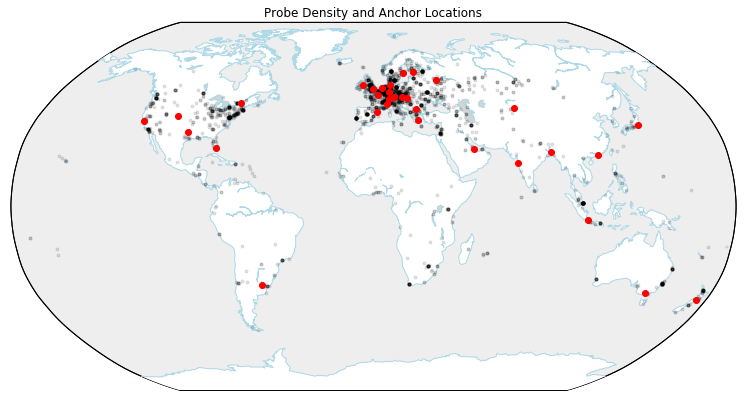

In [14]:
aloc_df = min_df.groupby(level=[0]).first().loc[:,['alon','alat']]
ploc_df = min_df.groupby(level=[1]).first().loc[:,['plon','plat']]

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(13,10))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines(color='lightblue')
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawmapboundary(fill_color='#eeeeee')
plt.title("Probe Density and Anchor Locations")
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,"k.",alpha=0.1)
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

Now we need some functions for drawing circles on projected maps:

In [15]:
def pointAtBearing(lon1, lat1, b, r):
    lon1 = lon1 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0 # convert to radians

    b = (b / 90) * math.pi / 2


    lat2 = math.asin(math.sin(lat1) * math.cos(r) + math.cos(lat1) * math.sin(r) * math.cos(b))
    lon2 = lon1 + math.atan2(math.sin(b) * math.sin(r) * math.cos(lat1), 
                             math.cos(r) - math.sin(lat1) * math.sin(lat2))
    
    lon2 = 180.0 * lon2 / math.pi
    lat2 = 180.0 * lat2 / math.pi

    return lon2, lat2

def circleWithRadius(lon, lat, km):
    """
    Return lat/lon coordinate vectors of a circle 
    with a given radius r (in units of Earth radius)
    """
    latArray = []
    lonArray = []
    
    for bearing in range(0,360):
        lon2, lat2 = pointAtBearing(lon, lat, bearing, km / 6371)
        latArray.append(lat2)
        lonArray.append(lon2)
        
    return lonArray, latArray

def plot_exclusion_circles(aid, km_range=(5,1000), max_rtt=None, max_probes=None, mapscale=None):
    # First, get a dataframe containing only the datapoints for the anchor
    amin_df = min_df.loc[aid]
    
    # Drop probes that are outside the distance range
    amin_df = amin_df[amin_df['km'] < max(km_range)]
    amin_df = amin_df[amin_df['km'] > min(km_range)]
    
    # If distance range leads to too few probes, drop it
    if len(amin_df) < 3:
        amin_df = min_df.loc[aid]
    
    # Drop probes over max RTT
    if max_rtt is not None:
        amin_df = amin_df[amin_df['minrtt'] < max_rtt]
        # If max RTT leads to too few probes, drop it
        if len(amin_df) < 3:
            amin_df = min_df.loc[aid]

    if max_probes is not None and len(amin_df) > max_probes:
        amin_df = amin_df.sample(max_probes)

    # Now draw the basemap, scaled to fit most of the circles we'll draw
    if mapscale is None:
        mapscale = amin_df['rtt_km'].max() * 2000 + (max(km_range) * 500)
    alon = amin_df.iloc[0]['alon']
    alat = amin_df.iloc[0]['alat']
    plt.figure(figsize=(10,10))
    try:
        m = Basemap(width=mapscale,height=mapscale,
                    resolution='i',projection='laea',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    except ValueError:
        m = Basemap(resolution='i',projection='robi',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='#dddddd')
    m.drawmapboundary(fill_color='#dddddd')

    # Now plot circles
    for index, row in amin_df.iterrows():
        x, y = m(row['plon'],row['plat'])
        km = row['rtt_km']
        clon, clat = circleWithRadius(row['plon'], row['plat'], km)
        X, Y = m(clon, clat)
        plt.plot(X, Y, 'b-')
    
    # And plot a dot for the anchor
    x, y = m(alon, alat)
    plt.plot(x, y, "ro")
    
    # And title
    plt.title("Exclusion circles for {} probes around {}".format(len(amin_df), anchor_df.loc[aid]['name']))


Now select an anchor and draw a local map centered on it, and draw circles centered on all probes within a reasonable distance.

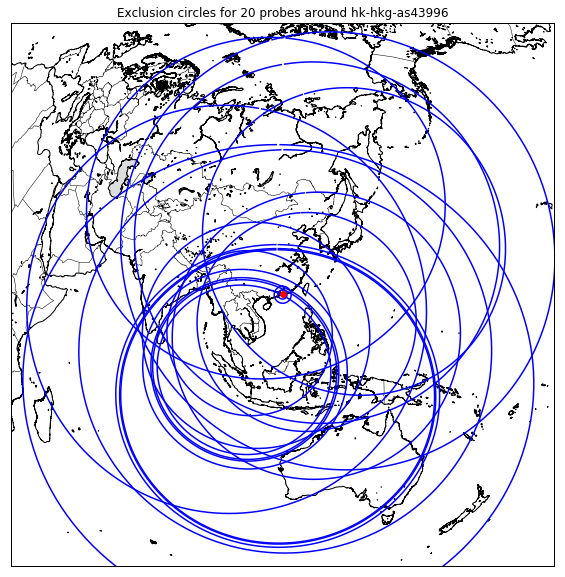

In [16]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(5,1000), max_rtt=100000, max_probes=20)

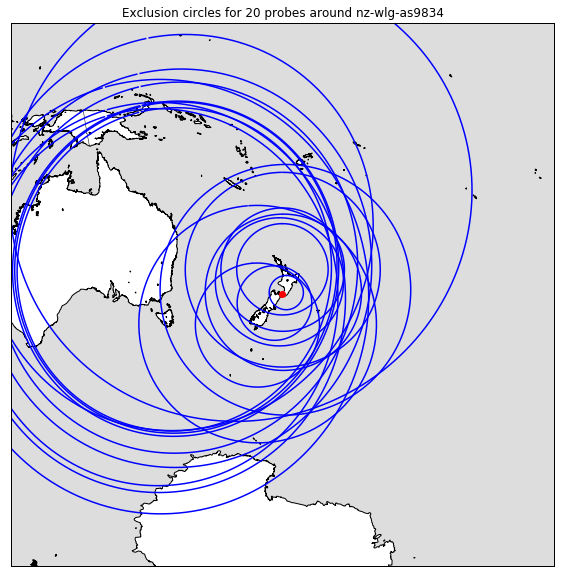

In [17]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

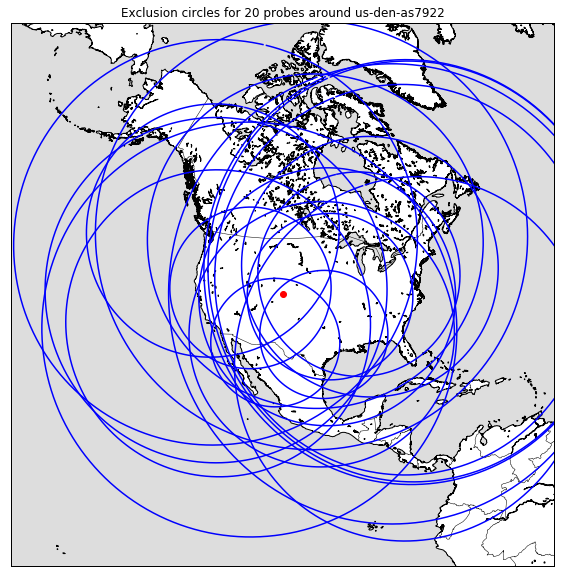

In [18]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

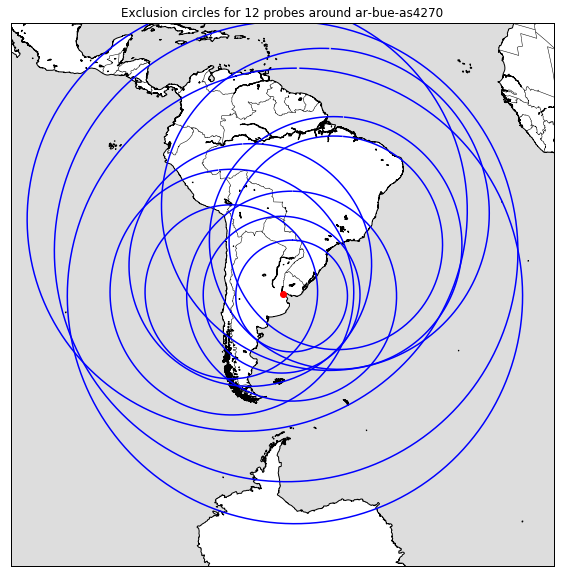

In [19]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

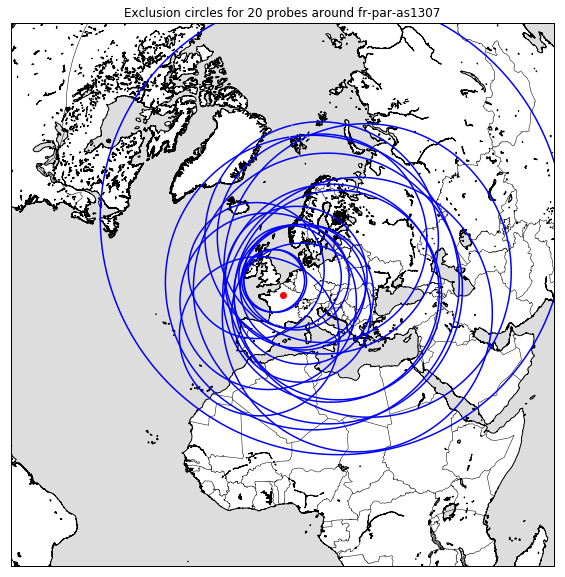

In [20]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

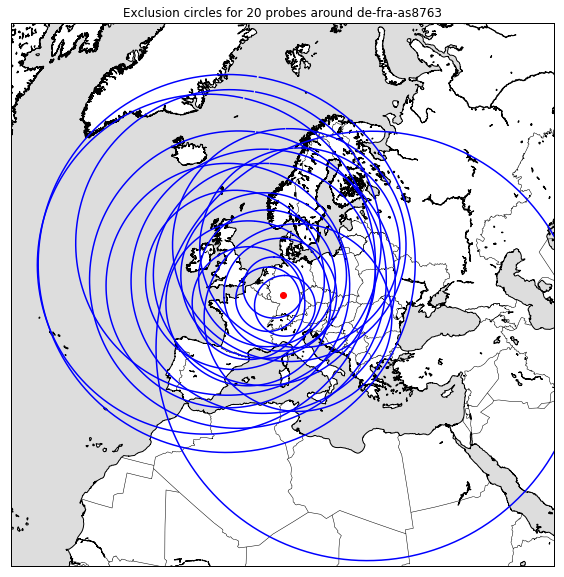

In [21]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

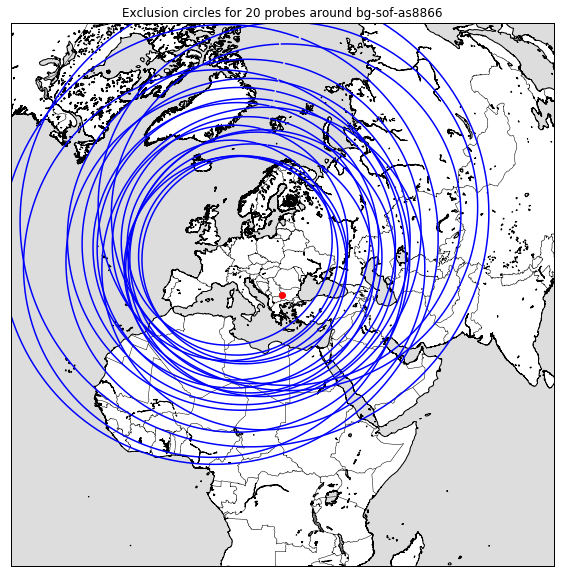

In [22]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

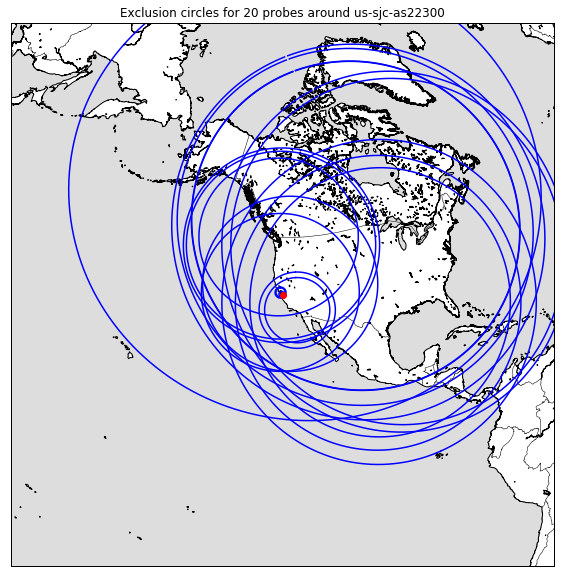

In [23]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)

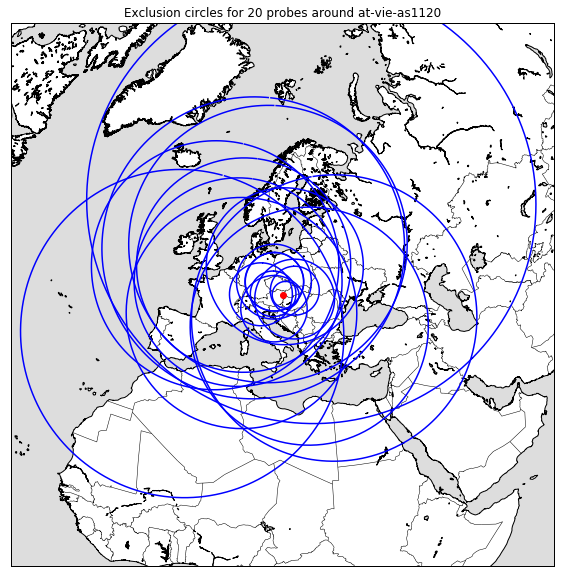

In [24]:
plot_exclusion_circles(np.random.choice(min_df.index.levels[0]), km_range=(20,3000), max_rtt=70000, max_probes=20)